In [35]:
# Import all the necessary libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [36]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving traffic_data.xlsx to traffic_data (1).xlsx


In [37]:
traffic_data = pd.read_excel('traffic_data.xlsx')
print(traffic_data.head())

                 Time  Intersection_1  Intersection_2  Intersection_3
0 2022-01-01 00:00:00             129             174             183
1 2022-01-01 01:00:00             117             117             201
2 2022-01-01 02:00:00             132             120             154
3 2022-01-01 03:00:00             150             164             230
4 2022-01-01 04:00:00             115             148             118


In [38]:
# Parse the time column and set it as the index
traffic_data['Time'] = pd.to_datetime(traffic_data['Time'])
traffic_data.set_index('Time', inplace=True)

# Normalize the dataset
scaler = MinMaxScaler()
traffic_data_scaled = scaler.fit_transform(traffic_data)

# Convert data to supervised learning format (X = features, y = labels)
def create_supervised_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Features: time_step rows of data
        y.append(data[i + time_step, :])     # Labels: the next row after time_step
    return np.array(X), np.array(y)


In [39]:

# Prepare the dataset with a time_step (e.g., 24 hours for daily prediction)
time_step = 24  # Use previous 24 hours to predict the next hour's traffic
X, y = create_supervised_dataset(traffic_data_scaled, time_step)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the input data to match RNN input shape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])



In [40]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=traffic_data.shape[1]))  # Output neurons = number of intersections (features)

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict traffic
predictions = model.predict(X_test)

# Rescale predictions back to original values
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)



Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.2030 - val_loss: 0.0194
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0413 - val_loss: 0.0166
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0279 - val_loss: 0.0174
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0233 - val_loss: 0.0161
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0208 - val_loss: 0.0163
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0196 - val_loss: 0.0161
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0190 - val_loss: 0.0161
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0180 - val_loss: 0.0161
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0179 - val_loss: 0.0161
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0175 - val_loss: 0.0160
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0172 - val_loss: 0.0161
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 

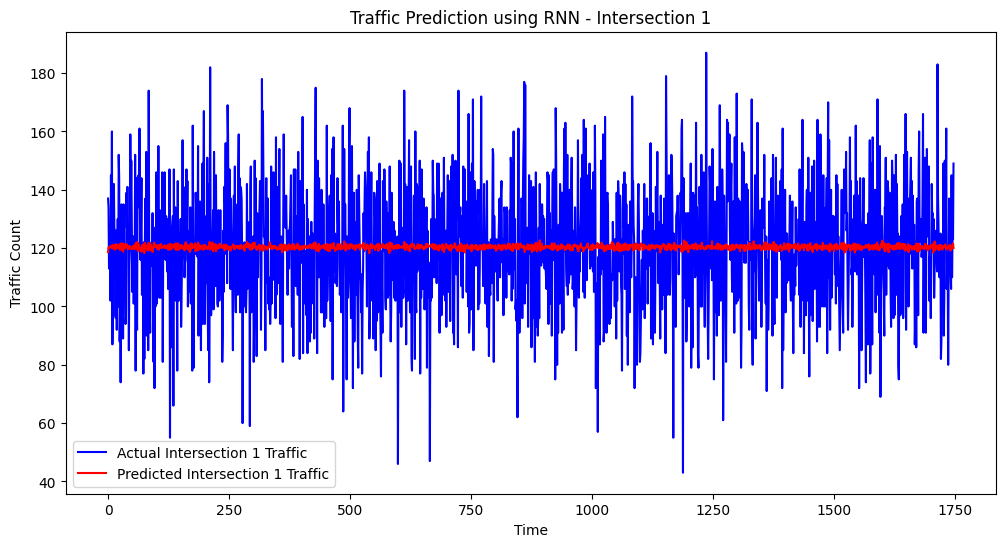

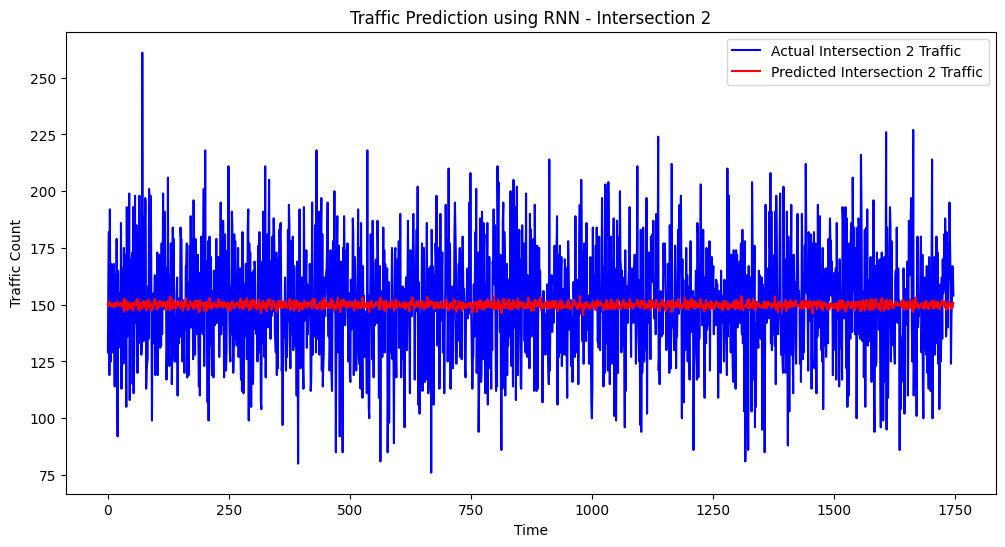

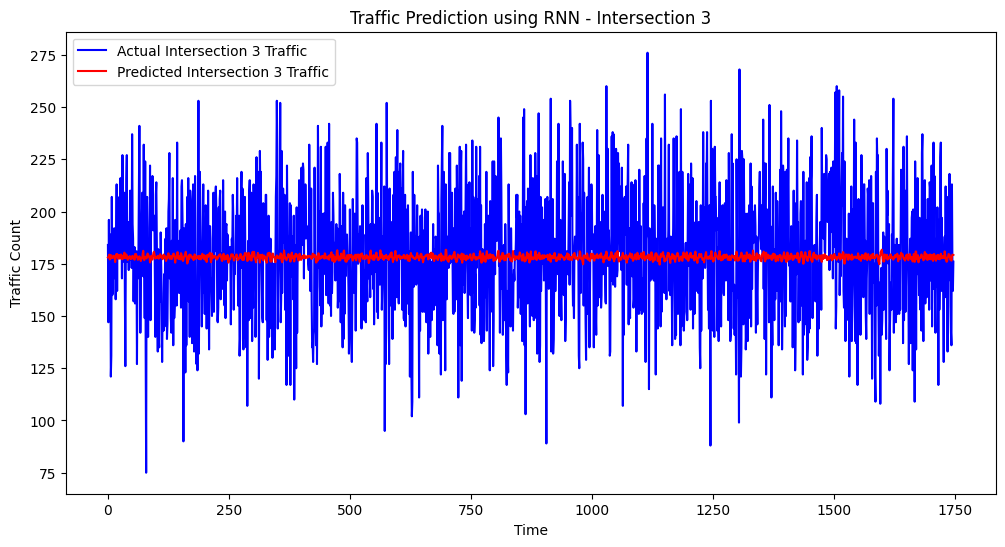

In [42]:
# Plot the actual vs predicted values for the first intersection
# Plot the actual vs predicted values for each intersection
for i in range(y_test_rescaled.shape[1]):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_rescaled[:, i], color='blue', label=f'Actual Intersection {i + 1} Traffic')
    plt.plot(predictions_rescaled[:, i], color='red', label=f'Predicted Intersection {i + 1} Traffic')
    plt.title(f'Traffic Prediction using RNN - Intersection {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.show()



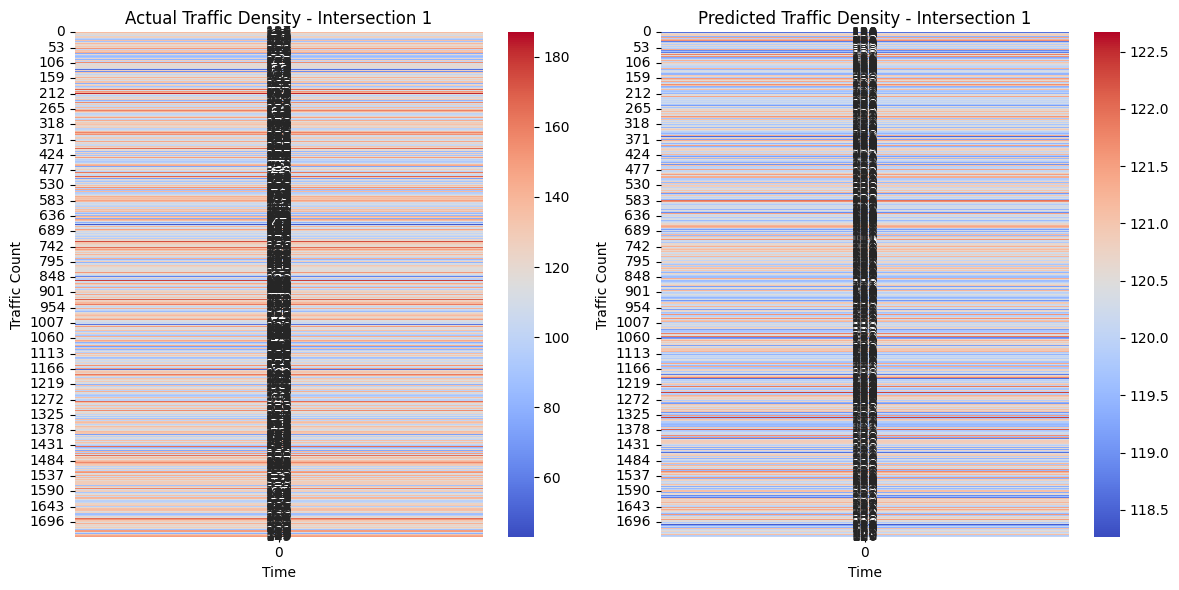

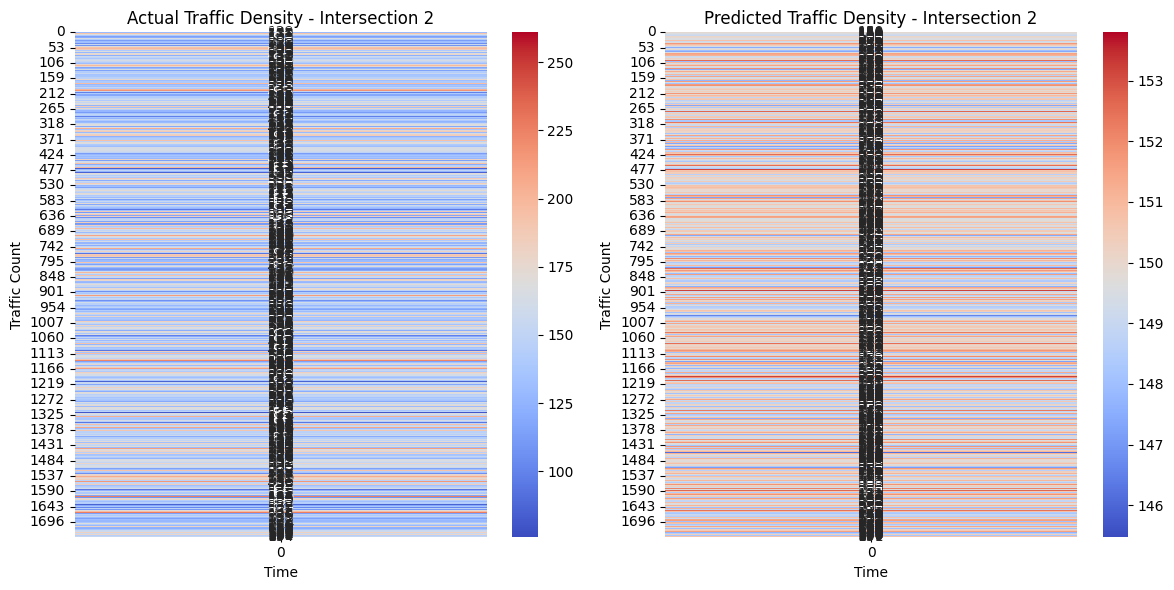

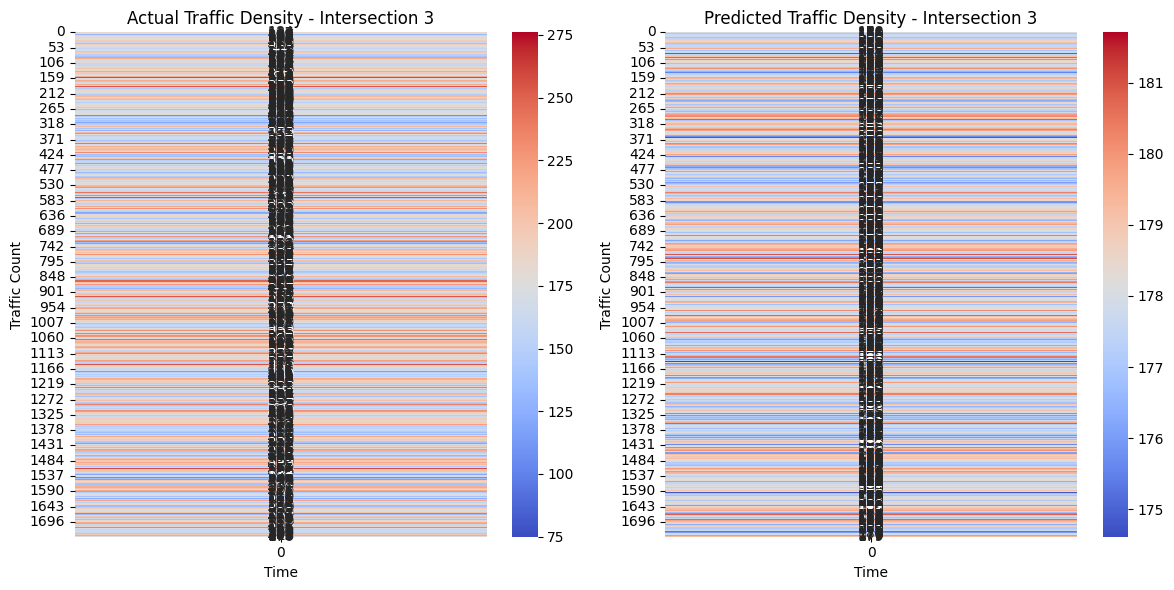

In [43]:
import seaborn as sns

# Define a function to plot the traffic density heatmap for each intersection
def plot_traffic_density_heatmap(actual, predicted, intersection_num):
    plt.figure(figsize=(12, 6))

    # Create a heatmap for actual traffic data
    plt.subplot(1, 2, 1)
    sns.heatmap(actual, cmap='coolwarm', annot=True, fmt='.0f', cbar=True)
    plt.title(f'Actual Traffic Density - Intersection {intersection_num}')
    plt.xlabel('Time')
    plt.ylabel('Traffic Count')

    # Create a heatmap for predicted traffic data
    plt.subplot(1, 2, 2)
    sns.heatmap(predicted, cmap='coolwarm', annot=True, fmt='.0f', cbar=True)
    plt.title(f'Predicted Traffic Density - Intersection {intersection_num}')
    plt.xlabel('Time')
    plt.ylabel('Traffic Count')

    plt.tight_layout()
    plt.show()

# Plot heatmaps for each intersection (1, 2, and 3)
for i in range(traffic_data.shape[1]):  # Loop through each intersection
    plot_traffic_density_heatmap(
        y_test_rescaled[:, i].reshape(-1, 1),
        predictions_rescaled[:, i].reshape(-1, 1),
        intersection_num=i+1
    )


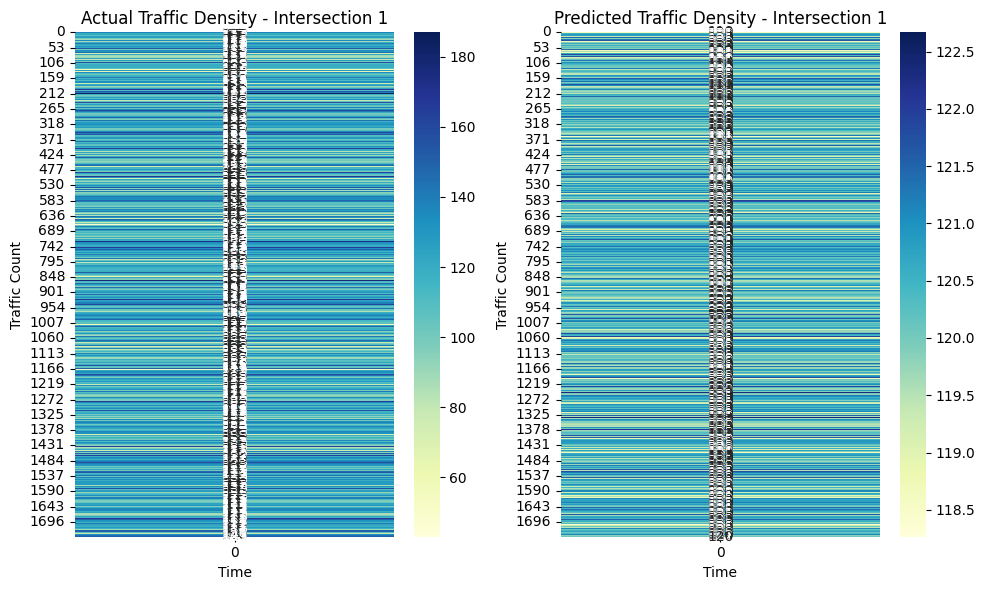

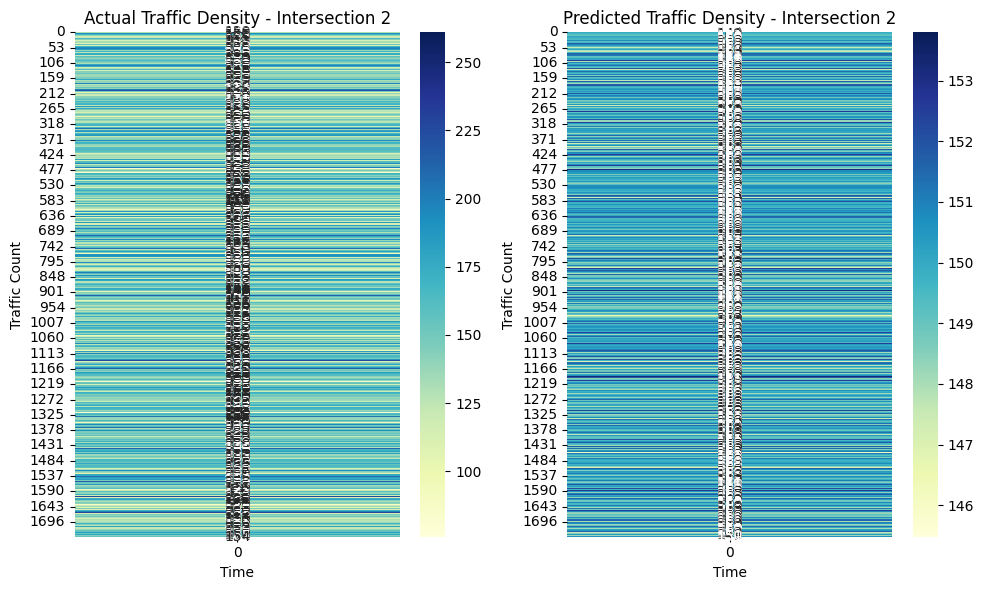

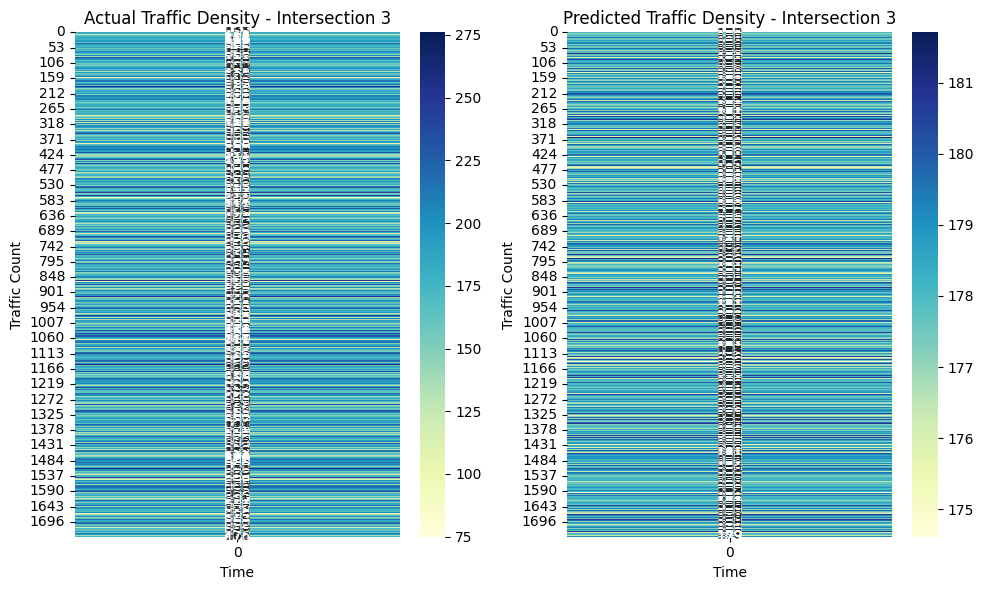

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap for actual and predicted traffic densities for each intersection
def plot_traffic_density_heatmap(actual, predicted, intersection_num):
    # Create a heatmap for actual traffic data
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(actual.reshape(-1, 1), cmap='YlGnBu', annot=True, fmt='.0f', cbar=True)
    plt.title(f'Actual Traffic Density - Intersection {intersection_num}')
    plt.xlabel('Time')
    plt.ylabel('Traffic Count')

    # Create a heatmap for predicted traffic data
    plt.subplot(1, 2, 2)
    sns.heatmap(predicted.reshape(-1, 1), cmap='YlGnBu', annot=True, fmt='.0f', cbar=True)
    plt.title(f'Predicted Traffic Density - Intersection {intersection_num}')
    plt.xlabel('Time')
    plt.ylabel('Traffic Count')

    plt.tight_layout()
    plt.show()

# Loop over each intersection and plot the heatmaps for actual and predicted traffic
for i in range(traffic_data.shape[1]):  # Loop through each intersection
    plot_traffic_density_heatmap(
        y_test_rescaled[:, i],
        predictions_rescaled[:, i],
        intersection_num=i+1
    )


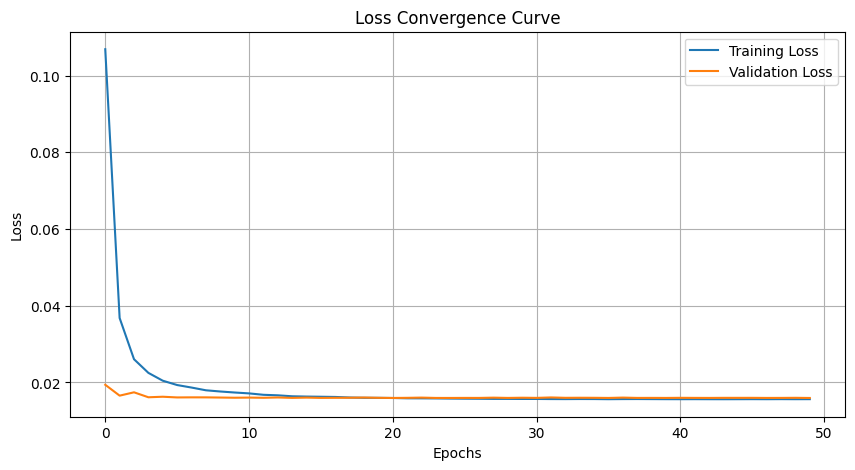

Mean Squared Error (MSE): 638.26
R-squared (R²): -0.00


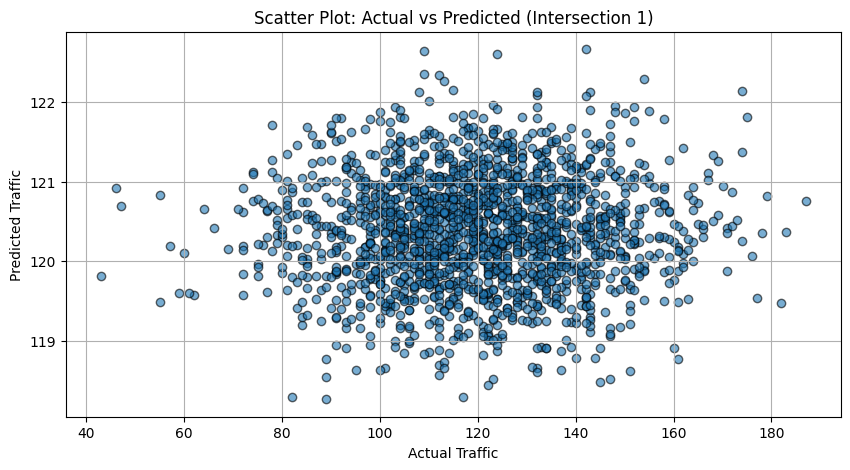

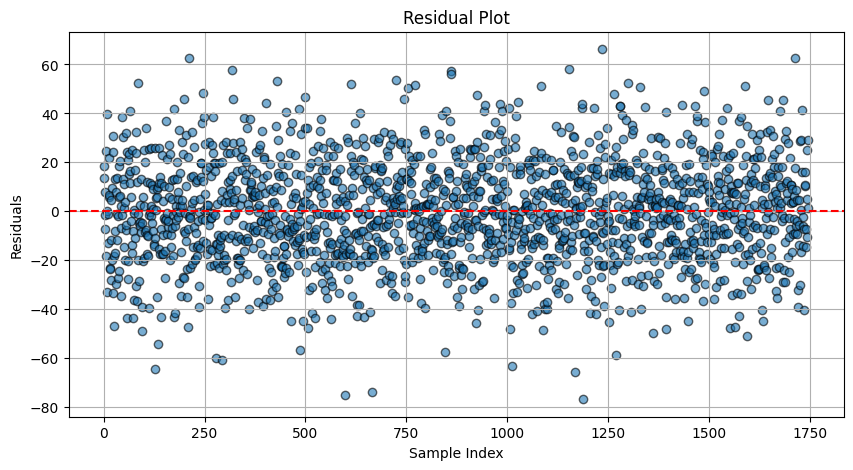

In [45]:
from sklearn.metrics import roc_curve, auc, mean_squared_error, r2_score

# Loss Convergence Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Convergence Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# If classification: Compute ROC-AUC
def plot_roc_auc(y_test, predictions, label):
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title(f'ROC and AUC - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example for first intersection (if classification task)
# plot_roc_auc(y_test_rescaled[:, 0], predictions_rescaled[:, 0], 'Intersection 1')

# Regression Metrics
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R²): {r2:.2f}')

# Scatter Plot: Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test_rescaled[:, 0], predictions_rescaled[:, 0], alpha=0.6, edgecolors='k')
plt.title('Scatter Plot: Actual vs Predicted (Intersection 1)')
plt.xlabel('Actual Traffic')
plt.ylabel('Predicted Traffic')
plt.grid(True)
plt.show()

# Residual Plot: Errors
residuals = y_test_rescaled[:, 0] - predictions_rescaled[:, 0]
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals)), residuals, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [46]:

# Save the model for future use
model.save('traffic_prediction_rnn_model.h5')